# Greenest Pixel Composite

For a given analysis tile, use a time series analysis to select greenest pixels for the time window. Based on the Greenest pixel select matching pixels from other bands to use in the derivation of covariates related to plant indicators.

In [1]:
import json
import os
import rasterio as rio
import geopandas as gpd
from shapely.geometry import box
from fiona.crs import from_epsg
from rasterio.mask import mask
from rasterio.warp import *
from rasterio.merge import merge
from rasterio import windows
import numpy as np
import matplotlib.pyplot as plt
#import rioxarray as rxr

import sys


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# Get bbox extent
geojson_path = '/projects/maap-users/alexdevseed/boreal_tiles_latlong.geojson'
bbox_ID = 40349
#in_crs = CRS.from_epsg(4326)

# open geojson and get co-ords of tile ID
with open(geojson_path) as j:
    response = json.load(j)
    in_bbox = rio.features.bounds(response['features'][bbox_ID-1]['geometry'])

print('in_bbox = ', in_bbox)


in_bbox =  (-117.3, 50.6, -117.0, 50.9)


In [3]:
# TODO: Clean up by using var for first part of datapath
GeoJson_file = '/projects/maap-users/alexdevseed/landsat8/sample2/'
## open json
## parses json file and returns local filepaths
## outputs a listof the local filepaths
def GetBandLists(inJSON, bandnum):
    with open(inJSON) as f:
        response = json.load(f)
    
    BandList = []
    for i in range(len(response['features'])):
        try:
            getBand = response['features'][i]['assets']['SR_B' + str(bandnum) + '.TIF']['href']
            BandList.append(getBand)
        except exception as e:
            print(e)

    BandList.sort()
    return BandList


BLUEBands = GetBandLists(os.path.join(GeoJson_file,'local-2018.json'), 2)
GREENBands = GetBandLists(os.path.join(GeoJson_file,'local-2018.json'), 3)
REDBands = GetBandLists(os.path.join(GeoJson_file,'local-2018.json'), 4)
NIRBands = GetBandLists(os.path.join(GeoJson_file,'local-2018.json'), 5)
SWIRBands = GetBandLists(os.path.join(GeoJson_file,'local-2018.json'), 6)

#print("file locations of red bands over ROI = ", REDBands)
#print("file locations of nir bands over ROI = ", NIRBands)

#LS8_file = BLUEBands[0]

In [4]:
#### For Testing Only ####
# Filter the list to data we know matches the tile - TODO: fix the query in 3.1.1 to use the same tile
import re
filter_list = ['043025','044024','044025']
pattern = re.compile("|".join(filter_list))

BLUEBands = [i for i in BLUEBands if pattern.search(i)]
GREENBands = [i for i in GREENBands if pattern.search(i)]
REDBands = [i for i in REDBands if pattern.search(i)]
NIRBands = [i for i in NIRBands if pattern.search(i)]
SWIRBands = [i for i in SWIRBands if pattern.search(i)]

In [10]:
## read all bands as masked arrays
## read each object in each list as a masked array 

def define_raster(file, in_bbox, epsg="epsg:4326"):
    '''Read the first raster to get its transform and crs'''
    with rio.open(file, 'r') as f:
        bbox = transform_bounds(epsg, f.crs, *in_bbox)
        #w = windows.from_bounds(*bbox, transform=f.transform)
        #band = f.read(1, window=w, masked=True)
        band, out_transform = merge([f],bounds=bbox)
    return f.crs, out_transform
        
def MaskArrays(file, in_bbox, epsg="epsg:4326"):
    '''Read a window of data from the raster matching the tile bbox'''
    print(file)
    with rio.open(file, 'r') as f:
        bbox = transform_bounds(epsg, f.crs, *in_bbox)
        #w = windows.from_bounds(*bbox, transform=f.transform)
        #band = f.read(1, window=w, masked=True)
        band, out_transform = merge([f],bounds=bbox)
    return np.ma.masked_array(band[0].astype(float), mask=f.nodata)

def CreateNDVIstack(REDfile, NIRfile, in_bbox):
    '''Calculate NDVI for each source scene'''
    print("Creating NDVI layer ")
    NIRarr = MaskArrays(NIRfile, in_bbox)
    REDarr = MaskArrays(REDfile, in_bbox)
    return np.ma.array((NIRarr-REDarr)/(NIRarr+REDarr))



In [11]:
## create NDVI layers
## Loopsover lists of bands and calculates NDVI
## creates a new list of NDVI images, one per input scene

# tmp hack to subset list
subset = range(0,5)
redFiles = [REDBands[x] for x in subset]
NIRFiles = [NIRBands[x] for x in subset]
greenFiles = [GREENBands[x] for x in subset]
blueFiles = [BLUEBands[x] for x in subset]
SWIRFiles = [SWIRBands[x] for x in subset]

out_crs, out_transform = define_raster(redFiles[0], in_bbox, epsg="epsg:4326")
NDVIstack = [CreateNDVIstack(redFiles[i],NIRFiles[i],in_bbox) for i in range(len(redFiles))]
print(np.shape(NDVIstack))
print('finished')


Creating NDVI layer 
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_043025_20180712_20200831_02_T1/LC08_L2SP_043025_20180712_20200831_02_T1_SR_B5.TIF
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_043025_20180712_20200831_02_T1/LC08_L2SP_043025_20180712_20200831_02_T1_SR_B4.TIF
Creating NDVI layer 
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044024_20180617_20200831_02_T1/LC08_L2SP_044024_20180617_20200831_02_T1_SR_B5.TIF
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044024_20180617_20200831_02_T1/LC08_L2SP_044024_20180617_20200831_02_T1_SR_B4.TIF
Creating NDVI layer 
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044024_20180820_20200831_02_T1/LC08_L2SP_044024_20180820_20200831_02_T1_SR_B5.TIF
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044024_20180820_20200831_02_T1/LC08_L2SP_044024_20180820_20200831_02_T1_SR_B4.TIF
Creating NDVI layer 
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044024_20180905_20200831_02_T1/LC08_L2SP_044024_20180905_20200831_02_T1_SR_B5.TIF

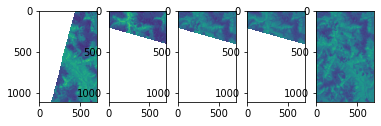

In [15]:
n: int = len(NDVIstack)
f = plt.figure()
for i in range(n):
    # Debug, plot figure
    f.add_subplot(1, n, i + 1)
    plt.imshow(NDVIstack[i])

plt.show(block=True)

2584088
2370757
(5, 1114, 708)
(1114, 708)


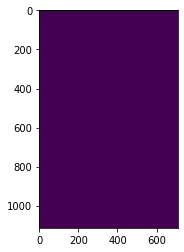

In [16]:
print(np.argmin(NDVIstack)) # not a useful number
print(np.argmax(NDVIstack))
print(np.shape(NDVIstack))

MaxNDVI = np.ma.max(np.ma.array(NDVIstack),axis=0)
BoolMask = np.ma.getmask(MaxNDVI)

del MaxNDVI

plt.imshow(BoolMask)
print(BoolMask.shape)

(1114, 708)


Text(0, 0.5, '$\\bf{Image Location}$')

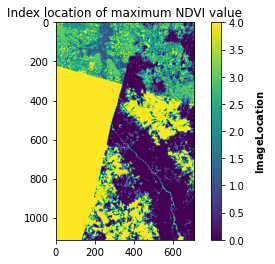

In [17]:
## get the index positions of the max NDVI value
## Get the argmax index positions from the stack of NDVI images

#Avoid slice of all nan
#NDVIstack[NDVIstack==np.nan] = 0

NDVIstack = np.ma.array(NDVIstack)
NDVImax = np.nanargmax(NDVIstack,axis=0)
print(np.shape(NDVImax))
## create a tmp array (binary mask) of the same input shape
NDVItmp = np.ma.zeros(NDVIstack.shape, dtype=bool)

## for each dimension assign the index position (flattens the array to a LUT)
for i in range(np.shape(NDVIstack)[0]):
    NDVItmp[i,:,:]=NDVImax==i
    

plt.imshow(np.ma.masked_array(NDVImax, BoolMask), cmap='viridis')
plt.title("Index location of maximum NDVI value")
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel(r"$\bf{Image Location}$",  labelpad=10, rotation=90)  
#plt.savefig('/projects/bobafett/LandsatComposites/Landsat_MaxNDVIIdx.png', format='PNG')

In [18]:
## Return Red value based on NDVI max index position

# insert the bands as arrays (made earlier)
## creates a single layer by using the binary mask
## and a sum function to collapse n-dims to 2-dims
def CollapseBands(inArr, NDVItmp, BoolMask):
    inArr = np.ma.masked_equal(inArr, 0)
    inArr[np.logical_not(NDVItmp)]=0 
    compImg = np.ma.masked_array(inArr.sum(0), BoolMask)
    return compImg

    
def CreateComposite(file_list, NDVItmp, BoolMask, in_bbox):
    MaskedFile = [MaskArrays(file_list[i], in_bbox) for i in range(len(file_list))]
    Composite=CollapseBands(MaskedFile, NDVItmp, BoolMask)
    # write files to disk here
    return Composite

def Write_to_disk(comp_stack, out_name):
    #TODO: full COG writing: higher compression, overviews, tile size, nodata
    kwargs=({'driver':'GTiff',
             'height':comp_stack.shape[0],
             'width':comp_stack.shape[1],
             'count':comp_stack.shape[2],
             'dtype':comp_stack.dtype,
             'crs':out_crs,
             'transform':out_transform,
             'compress':'deflate'
            })
    with rasterio.open(out_name, 'w', **kwargs) as dst:
        dst.write(np.moveaxis(comp_stack, [0, 1, 2], [2, 1, 0]))


In [21]:
RedComp = CreateComposite(redFiles, NDVItmp, BoolMask, in_bbox)
BlueComp = CreateComposite(blueFiles, NDVItmp, BoolMask, in_bbox)
GreenComp = CreateComposite(greenFiles, NDVItmp, BoolMask, in_bbox)
NDVIComp = CollapseBands(NDVIstack, NDVItmp, BoolMask)

/projects/alexdevseed/landsat8/sample2/LC08_L2SP_043025_20180712_20200831_02_T1/LC08_L2SP_043025_20180712_20200831_02_T1_SR_B4.TIF
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044024_20180617_20200831_02_T1/LC08_L2SP_044024_20180617_20200831_02_T1_SR_B4.TIF
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044024_20180820_20200831_02_T1/LC08_L2SP_044024_20180820_20200831_02_T1_SR_B4.TIF
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044024_20180905_20200831_02_T1/LC08_L2SP_044024_20180905_20200831_02_T1_SR_B4.TIF
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044025_20180820_20200831_02_T1/LC08_L2SP_044025_20180820_20200831_02_T1_SR_B4.TIF
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_043025_20180712_20200831_02_T1/LC08_L2SP_043025_20180712_20200831_02_T1_SR_B2.TIF
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044024_20180617_20200831_02_T1/LC08_L2SP_044024_20180617_20200831_02_T1_SR_B2.TIF
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044024_20180820_20200831_02_T1/LC0

In [22]:
comp_stack = np.dstack([RedComp, BlueComp, GreenComp, NDVIComp])
outdir = '/projects/bobafett/LandsatComposites/LandsatComposites'
out_name = os.path.join(outdir, 'Landsat8_' + str(bbox_ID) + '_comp.tif')
Write_to_disk(comp_stack, out_name)

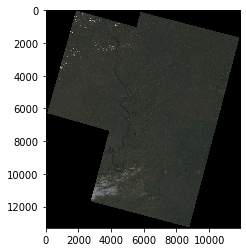

In [10]:
# TEST CELLS AND PLOTS

def norm(band):
    band_min, band_max = band.min(), band.max()
    scale = ((band - band_min)/(band_max - band_min))*255
    return scale.astype(np.ubyte)

def RGBstack(b2, b3, b4):
    b2 = norm(b2)
    b3 = norm(b3)
    b4 = norm(b4)

    rgb = np.ma.dstack((b4,b3,b2))

    return rgb

rgb = RGBstack(BlueComp,GreenComp,RedComp)

plt.imshow(rgb)

# hack to free up memory
del rgb, BlueComp, GreenComp
#del BlueComp, GreenComp, rgb
#cbar1.ax.set_ylabel(r"$\bf{Reflectance}$",  labelpad=10, rotation=90)  
#plt.savefig('/projects/bobafett/LandsatComposites/Landsat_RGBComposite.png', format='PNG')

In [11]:
## Create Indices of interest from new composites
NIRComp = CreateComposite(NIRFiles, NDVItmp, BoolMask)


/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B5_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B5_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B5_warp.tif
calculating Red edge (Simple ratio)...


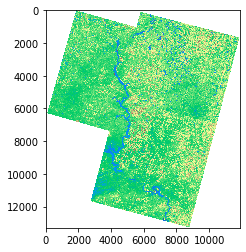

In [12]:
plt.imshow(np.ma.masked_array(REComp, BoolMask), cmap="terrain")